In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
l_encode=LabelEncoder()

In [2]:
df_train=pd.read_csv('/Users/aeternae/Desktop/Data/titanic/train.csv')
df_test=pd.read_csv('/Users/aeternae/Desktop/Data/titanic/test.csv')

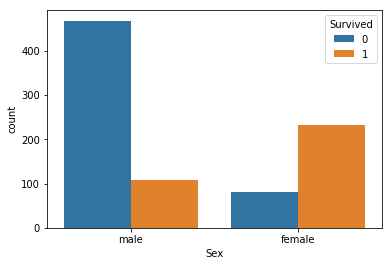

In [3]:
df_train.groupby('Sex').count()
sns.countplot(x='Sex',hue='Survived',data=df_train)

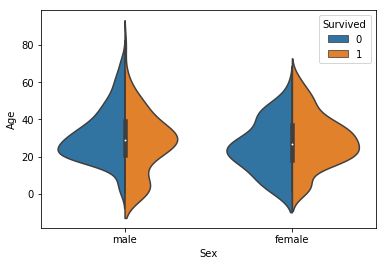

In [4]:
sns.violinplot(x='Sex',y='Age',hue='Survived',data=df_train,split=True)

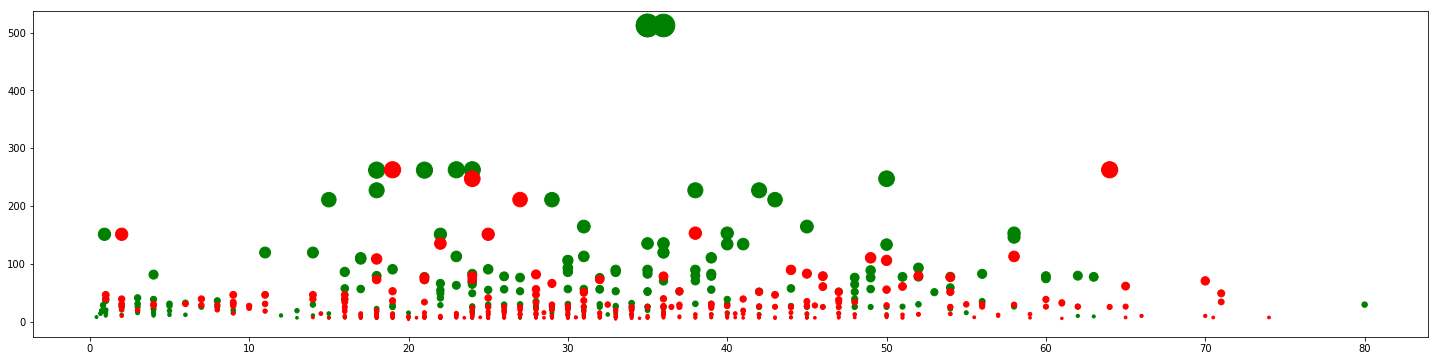

In [5]:
plt.figure(figsize=[25,6])
plt.scatter(df_train[df_train['Survived']==1]['Age'],df_train[df_train['Survived']==1]['Fare'],c='g',s=df_train[df_train['Survived']==1]['Fare'])
plt.scatter(df_train[df_train['Survived']==0]['Age'],df_train[df_train['Survived']==0]['Fare'],c='r',s=df_train[df_train['Survived']==0]['Fare'])

In [6]:
def process_family():
    global df
    df['FamilySize']=df['SibSp']+df['Parch']+1
    df['Alone']=df['FamilySize'].map(lambda s:1 if s==1 else 0)
    df['SmallFamily']=df['FamilySize'].map(lambda s:1 if 1<s<=4 else 0)
    df['BigFamily']=df['FamilySize'].map(lambda s:1 if s>4 else 0)
    return df

In [7]:
def process_embarked():
    global df
    df.Embarked.fillna('S',inplace =True)
    df_dummise=pd.get_dummies(df['Embarked'],prefix='Embarked')
    df=pd.concat([df,df_dummise],axis=1)
    df.drop('Embarked',inplace=True,axis=1)
    return df

In [8]:
def process_cabin():
    global df
    df.Cabin.fillna('X',inplace=True)
    df['Cabin']=df['Cabin'].map(lambda c :c[0])
    cabin_dummies=pd.get_dummies(df['Cabin'],prefix='Cabin')
    df=pd.concat([df,cabin_dummies],axis=1)
    df.drop('Cabin',inplace=True,axis=1)
    return df

In [9]:
def get_title():
    global df
    df['Title']=df['Name'].map(lambda name :name.split(',')[1].split('.')[0].strip())
    title_names = (df['Title'].value_counts() < 10)
    df['Title'] = df['Title'].apply(lambda x: 'Re' if title_names.loc[x] == True else x)
    return df

In [10]:
colums=df_train.columns
colums=colums.drop(['Survived'])
data1=df_train[colums]
df=pd.concat([data1,df_test],ignore_index=True,axis=0)
#data2=df.iloc[0:891,:]

In [11]:
df=get_title()
df_group=df.groupby(['Sex','Pclass','Title']).median()
df_group=df_group.reset_index()[['Sex','Pclass','Title','Age']]

In [12]:
def fill_age(row):
    condition=((row['Sex']==df_group['Sex'])&(row['Pclass']==df_group['Pclass'])&(row['Title']==df_group['Title']))
    if np.isnan(df_group[condition]['Age'].values[0]):
        condition=((row['Sex']==df_group['Sex'])&(row['Pclass']==df_group['Pclass']))
    return df_group[condition]['Age'].values[0]

In [13]:
def process_age():
    global df
    ###axis=1
    df['Age']=df.apply(lambda row: fill_age(row)if np.isnan(row['Age']) else row['Age'],axis=1)
    df['AgeBin']=pd.cut(df['Age'].astype(int),6)
    df['AgeBinCode']=l_encode.fit_transform(df['AgeBin'])
    df.drop(['AgeBin','Age'],inplace=True,axis=1)
    return df

In [14]:
def process_name():
    global df
    #df.drop('Name',inplace=True,axis=1)
    title_dummies=pd.get_dummies(df['Title'],prefix='Title')
    df=pd.concat([df,title_dummies],axis=1)
    df.drop('Title',inplace=True,axis=1)
    return df

In [15]:
def process_sex():
    global df 
    df['Sex_code']=l_encode.fit_transform(df['Sex'])
    df.drop('Sex',inplace=True,axis=1)
    return df

In [16]:
def process_fare():
    global df
    df.loc[df['PassengerId']==1044,'Fare']=7
    df['FareBin']=pd.qcut(df['Fare'],3)
    df['FareBinCode']=l_encode.fit_transform(df['FareBin'])
    #df.drop(['FareBin','Fare'],inplace=True,axis=1)
    return df

In [17]:
df1=pd.DataFrame(np.zeros((df.shape[0],6)),columns=['P1Male','P2Male','P3Male','P1Female','P2Female',"P3Female"])
df=pd.concat([df,df1],axis=1)

In [18]:
def process_psex():
    global df 
    df.loc[((df['Sex_code']==1)&(df['Pclass']==1)),'P1Male']=1
    df.loc[((df['Sex_code']==1)&(df['Pclass']==2)),'P2Male']=1
    df.loc[((df['Sex_code']==1)&(df['Pclass']==3)),'P3Male']=1
    df.loc[((df['Sex_code']==0)&(df['Pclass']==1)),'P1Female']=1
    df.loc[((df['Sex_code']==0)&(df['Pclass']==2)),'P2Female']=1
    df.loc[((df['Sex_code']==0)&(df['Pclass']==3)),'P3Female']=1
    return df

In [19]:
def process_ticket():
    Ticket = []
    global df
    for i in list(df.Ticket):
        if not i.isdigit() :
            Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0][0]) #Take prefix
        else:
            Ticket.append("X")        
    df["Ticket"] = Ticket
    ticket=pd.get_dummies(df.Ticket,prefix="Ticket")
    df=pd.concat([df,ticket],axis=1)
    return df 

In [20]:
df=process_family()
df=process_cabin()
df=process_embarked()
df=process_age()
df=process_name()
df=process_sex()
df=process_fare()
df=process_psex()
df=process_ticket()

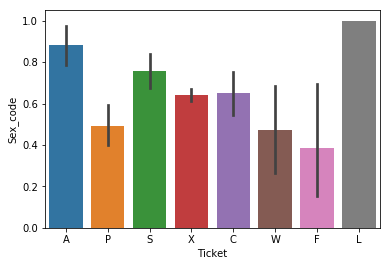

In [21]:
sns.barplot(df.Ticket,df.Sex_code)

In [22]:
df_train_process=df.iloc[0:891,:]
df_test_process=df.iloc[891:,:]
df_train_process=pd.concat([df_train_process,df_train.Survived],axis=1)

In [23]:
df_train_process.columns

Index(['PassengerId', 'Pclass', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'P1Male', 'P2Male', 'P3Male', 'P1Female', 'P2Female', 'P3Female',
       'FamilySize', 'Alone', 'SmallFamily', 'BigFamily', 'Cabin_A', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
       'Cabin_X', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'AgeBinCode',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Re',
       'Sex_code', 'FareBin', 'FareBinCode', 'Ticket_A', 'Ticket_C',
       'Ticket_F', 'Ticket_L', 'Ticket_P', 'Ticket_S', 'Ticket_W', 'Ticket_X',
       'Survived'],
      dtype='object')

In [24]:
use_columns=[ 'Pclass',
       'Alone', 'SmallFamily', 'BigFamily', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'AgeBinCode', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Re', 'Sex_code', 'FareBinCode', 'P1Male', 'P2Male', 'P3Male', 'P1Female', 'P2Female', 'P3Female',
             
           ]
#'Ticket_A', 'Ticket_C', 'Ticket_F', 'Ticket_L', 'Ticket_P', 'Ticket_S', 'Ticket_W', 'Ticket_X','Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
      # 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X',
# 'Cabin_A', 'Cabin_B', 'Cabin_C','Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'FamilySize'
# ,'Ticket_A', 'Ticket_C', 'Ticket_F', 'Ticket_L', 'Ticket_P', 'Ticket_S', 'Ticket_W', 'Ticket_X','Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
      # 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X',

In [25]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

/Users/aeternae/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [26]:
kfold = StratifiedKFold(n_splits=10,shuffle=True, random_state=0)

In [27]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import xgboost as xgb
import lightgbm as lgb

   CrossValMeans  CrossValerrors           Algorithm
0       0.842879        0.044254                 SVC
1       0.830531        0.042681            AdaBoost
2       0.845139        0.042074        RandomForest
3       0.842892        0.036792          ExtraTrees
4       0.833915        0.049691    GradientBoosting
5       0.836150        0.047618         KNeighboors
6       0.833915        0.034483  LogisticRegression
7       0.832817        0.049058                 xgb
8       0.839546        0.042989                 lgb


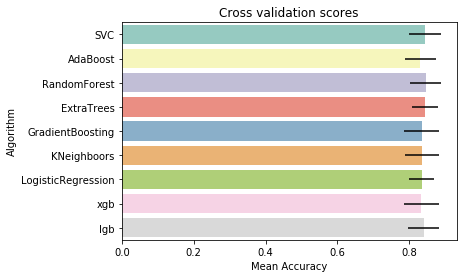

In [28]:
random_state = 2019
classifiers = []
classifiers.append(SVC(random_state=random_state,C=3,gamma=0.3,tol=0.15))#cross_val_score=0.8428790716150267,0.8686868686868687
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state,n_estimators=150,max_depth=15,criterion='gini',max_features=0.6,min_samples_leaf=2))
#0.8462623425263874,0.8641975308641975
#0.8440029508568834,0.8630751964085297
classifiers.append(ExtraTreesClassifier(random_state=random_state,n_estimators=150,max_depth=15,criterion='gini',max_features=0.5,min_samples_leaf=3))
#0.8440029508568834，0.8641975308641975
classifiers.append(GradientBoostingClassifier(random_state=random_state,n_estimators=180,max_depth=3,
                               max_features=0.3,min_samples_leaf=5,learning_rate=0.1))
classifiers.append(KNeighborsClassifier())
#C=3
classifiers.append(LogisticRegression(random_state = random_state,C=3))
#0.8383971739870617,0.8698092031425365
classifiers.append(xgb.XGBClassifier(random_state=random_state,n_estimators=500,max_depth=6,
                      learning_rate=0.1,subsample=.7,colsample_bytree=0.6,gamma=0.05))
#0.8406696175235501,0.8698092031425365
classifiers.append(lgb.LGBMClassifier(random_state=random_state,n_estimators=500,max_depth=-1,colsample_bytree=0.6))
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, df_train_process[use_columns], y = df_train_process['Survived'], scoring = "accuracy", cv = kfold, n_jobs=4))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","KNeighboors","LogisticRegression", "xgb", "lgb"]})
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")
print(cv_res)

In [29]:
param_grid={
     'n_estimators':[100,200],
     'criterion':['gini','entropy'],
     'max_depth':[None],
    'max_features':[.3,.5,.6],
     'min_samples_leaf':[2,4,6],
    'n_jobs':[-1],
 }
# param_grid={
#     'C':[1,2,3,4,5],
#     'gamma':[0.001,0.01,0.1,0.2,0.5]
# }
import lightgbm
lgb_clf=lightgbm.LGBMClassifier(n_estimators=500,max_depth=-1,colsample_bytree=0.6)
lgb_clf

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [30]:
# cross_val_score(lgb_clf,df_train_process[use_columns],df_train_process['Survived'],cv=kfold).mean()

In [31]:
df_test_process.columns

Index(['PassengerId', 'Pclass', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'P1Male', 'P2Male', 'P3Male', 'P1Female', 'P2Female', 'P3Female',
       'FamilySize', 'Alone', 'SmallFamily', 'BigFamily', 'Cabin_A', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
       'Cabin_X', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'AgeBinCode',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Re',
       'Sex_code', 'FareBin', 'FareBinCode', 'Ticket_A', 'Ticket_C',
       'Ticket_F', 'Ticket_L', 'Ticket_P', 'Ticket_S', 'Ticket_W', 'Ticket_X'],
      dtype='object')

In [32]:
gbm = xgb.XGBClassifier(
learning_rate = 0.1,
 n_estimators= 500,
 max_depth= 10,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.5,                        
 subsample=0.7,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

In [33]:
lgb_result = np.zeros(df_test_process.shape[0])

In [34]:
for i,(train,val)in enumerate(kfold.split(df_train_process[use_columns],df_train_process['Survived'])):
    x_train=df_train_process[use_columns].iloc[train]
    y_train=df_train_process[['Survived']].iloc[train]
    x_val=df_train_process[use_columns].iloc[val]
    y_val=df_train_process[['Survived']].iloc[val]
    gbm.fit(x_train,y_train,eval_set=[(x_val, y_val)],
              verbose=100,early_stopping_rounds=2000)
    #y_pre=gbm.predict(x_val)
    lgb_result+=gbm.predict(df_test_process[use_columns])
    print(gbm.score(x_val,y_val))

[0]	validation_0-error:0.255556
Will train until validation_0-error hasn't improved in 2000 rounds.
[100]	validation_0-error:0.244444


/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[200]	validation_0-error:0.244444
[300]	validation_0-error:0.244444
[400]	validation_0-error:0.255556
[499]	validation_0-error:0.255556
0.7777777777777778
[0]	validation_0-error:0.155556
Will train until validation_0-error hasn't improved in 2000 rounds.
[100]	validation_0-error:0.155556


/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[200]	validation_0-error:0.155556
[300]	validation_0-error:0.144444
[400]	validation_0-error:0.155556
[499]	validation_0-error:0.144444
0.9
[0]	validation_0-error:0.235955
Will train until validation_0-error hasn't improved in 2000 rounds.
[100]	validation_0-error:0.191011


/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[200]	validation_0-error:0.168539
[300]	validation_0-error:0.191011
[400]	validation_0-error:0.191011
[499]	validation_0-error:0.191011
0.8314606741573034
[0]	validation_0-error:0.157303
Will train until validation_0-error hasn't improved in 2000 rounds.
[100]	validation_0-error:0.134831


/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[200]	validation_0-error:0.134831
[300]	validation_0-error:0.134831
[400]	validation_0-error:0.134831
[499]	validation_0-error:0.123596
0.8764044943820225
[0]	validation_0-error:0.146067
Will train until validation_0-error hasn't improved in 2000 rounds.
[100]	validation_0-error:0.101124


/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[200]	validation_0-error:0.11236
[300]	validation_0-error:0.123596
[400]	validation_0-error:0.11236
[499]	validation_0-error:0.11236
0.898876404494382
[0]	validation_0-error:0.191011
Will train until validation_0-error hasn't improved in 2000 rounds.
[100]	validation_0-error:0.179775


/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[200]	validation_0-error:0.191011
[300]	validation_0-error:0.191011
[400]	validation_0-error:0.179775
[499]	validation_0-error:0.179775
0.8314606741573034
[0]	validation_0-error:0.213483
Will train until validation_0-error hasn't improved in 2000 rounds.
[100]	validation_0-error:0.191011


/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[200]	validation_0-error:0.202247
[300]	validation_0-error:0.213483
[400]	validation_0-error:0.202247
[499]	validation_0-error:0.213483
0.8426966292134831
[0]	validation_0-error:0.11236
Will train until validation_0-error hasn't improved in 2000 rounds.
[100]	validation_0-error:0.078652


/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[200]	validation_0-error:0.078652
[300]	validation_0-error:0.078652
[400]	validation_0-error:0.078652
[499]	validation_0-error:0.078652
0.9213483146067416
[0]	validation_0-error:0.157303
Will train until validation_0-error hasn't improved in 2000 rounds.
[100]	validation_0-error:0.134831


/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[200]	validation_0-error:0.134831
[300]	validation_0-error:0.134831
[400]	validation_0-error:0.123596
[499]	validation_0-error:0.134831
0.8764044943820225
[0]	validation_0-error:0.215909
Will train until validation_0-error hasn't improved in 2000 rounds.
[100]	validation_0-error:0.204545


/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/aeternae/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[200]	validation_0-error:0.193182
[300]	validation_0-error:0.181818
[400]	validation_0-error:0.204545
[499]	validation_0-error:0.193182
0.8295454545454546


In [35]:
cross_val_score(gbm,df_train_process[use_columns],df_train_process['Survived'],cv=kfold).mean()

0.8373110316649643

In [36]:
SVMC_best=SVC(random_state=random_state,C=3,gamma=0.3,tol=0.15,probability=True)#cross_val_score=0.8428790716150267,0.8686868686868687
ada_best=AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)
RFC_best=RandomForestClassifier(random_state=random_state,n_estimators=150,max_depth=15,criterion='gini',max_features=0.6,min_samples_leaf=2)
#0.8462623425263874,0.8641975308641975
#0.8440029508568834,0.8630751964085297
ExtC_best=ExtraTreesClassifier(random_state=random_state,n_estimators=150,max_depth=15,criterion='gini',max_features=0.5,min_samples_leaf=3)
#0.8440029508568834，0.8641975308641975
GBC_best=GradientBoostingClassifier(random_state=random_state,n_estimators=180,max_depth=3,
                               max_features=0.3,min_samples_leaf=5,learning_rate=0.1)
Knn_best=KNeighborsClassifier()
#C=3
Lr_best=LogisticRegression(random_state = random_state,C=3)
#0.8383971739870617,0.8698092031425365
Xgb_best=xgb.XGBClassifier(random_state=random_state,n_estimators=500,max_depth=6,
                      learning_rate=0.1,subsample=.7,colsample_bytree=0.6,gamma=0.05)
#0.8406696175235501,0.8698092031425365
Lgb_best=lgb.LGBMClassifier(random_state=random_state,n_estimators=500,max_depth=-1,colsample_bytree=0.6)

In [37]:
votingC =VotingClassifier(estimators=[('rfc', RFC_best), 
('svc', SVMC_best), ('gbc',GBC_best),('xgb',Xgb_best),('knn',Knn_best)], voting='soft', n_jobs=4)

In [38]:
votingC = votingC.fit(df_train_process[use_columns],df_train_process['Survived'])

In [39]:
votingC.score(df_train_process[use_columns],df_train_process['Survived'])

0.867564534231201

In [40]:
result=votingC.predict(df_test_process[use_columns])

In [41]:
df_test_process['Survived']=result.astype(int)
sumbit=df_test_process[['PassengerId','Survived']]
sumbit.to_csv('/Users/aeternae/Desktop/Data/titanic/submit_voting_hh410.csvh410.csv',index=False)

/Users/aeternae/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [42]:
gbm.fit(df_train_process[use_columns],df_train_process['Survived'])
gbm.score(df_train_process[use_columns],df_train_process['Survived'])

0.8653198653198653

In [43]:
lgb_result=lgb_result/5
lgb_result[lgb_result>0.5]=1
lgb_result[lgb_result<=0.5]=0
lgb_result.astype(int)
df_test_process['Survived']=lgb_result
sumbit=df_test_process[['PassengerId','Survived']]
sumbit.to_csv('/Users/aeternae/Desktop/Data/titanic/submit_gbm_x.csv',index=False)

/Users/aeternae/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
